PROBLEM: by including pre-2007 evictions, i'm no longer looking at evictions per unit per year bc there are no pre-2007 zero-eviction records. Pre-2007 records only appear if there is an eviction when we use a post-2007 asessor record to stand in for a pre-2007 property.

In [17]:
asr['pre_07_ev'] = asr['ev_count'] - asr['ev_count_post_07']

In [18]:
asr.groupby('asr_yr')['pre_07_ev'].sum()

asr_yr
2007    22627
2008      106
2009      105
2010      159
2011       61
2012       16
2013      166
2014      156
2015      133
2016      109
2017        0
Name: pre_07_ev, dtype: int64

<AxesSubplot:>

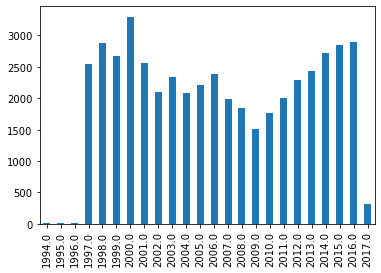

In [81]:
evictions['year'].value_counts(sort=False).plot(kind='bar')

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
evictions = pd.read_csv('../data/ev_matched_w_fips.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Check aggregation

In [18]:
evictions_07 = evictions[evictions['year'] > 2006]

In [21]:
asr_evic = pd.merge(asr, evictions, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))
asr_evic_07 = pd.merge(asr, evictions_07, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))

In [22]:
check_df = asr_evic.groupby('asr_index').agg({'index_evic':'count', 'ev_count':'min'})
check_df['all_evic_count'] = check_df['index_evic'] == check_df['ev_count']

In [23]:
check_df['all_evic_count'].all()

True

In [24]:
check_df_07 = asr_evic_07.groupby('asr_index').agg({'index_evic':'count', 'ev_count_post_07':'min'})
check_df_07['all_evic_count'] = check_df_07['index_evic'] == check_df_07['ev_count_post_07']

In [25]:
check_df_07['all_evic_count'].all()

True

### Main

In [84]:
asr = pd.read_csv('../data/asr_grouped_by_yr_w_fips.csv')

In [85]:
evictions = evictions[(evictions['year'] > 2009) & (evictions['year'] < 2017)]  # for per-year accuracy
evictions_from_14 = evictions[evictions['year'] > 2013]  #14,15,16
evictions_to_13 = evictions[evictions['year'] < 2013]  # 10,11,12

In [86]:
asr_evic_from_14 = pd.merge(asr, evictions_from_14, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))
asr_evic_to_13 = pd.merge(asr, evictions_to_13, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))

In [87]:
asr_evic_from_14 = asr_evic_from_14[((asr_evic_from_14['asr_yr'] > 2013) & ((asr_evic_from_14['asr_yr'] < 2017)))]

In [88]:
asr_evic_from_14['asr_yr'].value_counts()

2016    159553
2015    158935
2014    158291
Name: asr_yr, dtype: int64

In [89]:
asr_evic_to_13 = asr_evic_to_13[((asr_evic_to_13['asr_yr'] < 2013) & ((asr_evic_to_13['asr_yr'] > 2009)))]

In [90]:
asr_evic_to_13['asr_yr'].value_counts()

2012    156859
2010    156416
2011    150039
Name: asr_yr, dtype: int64

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

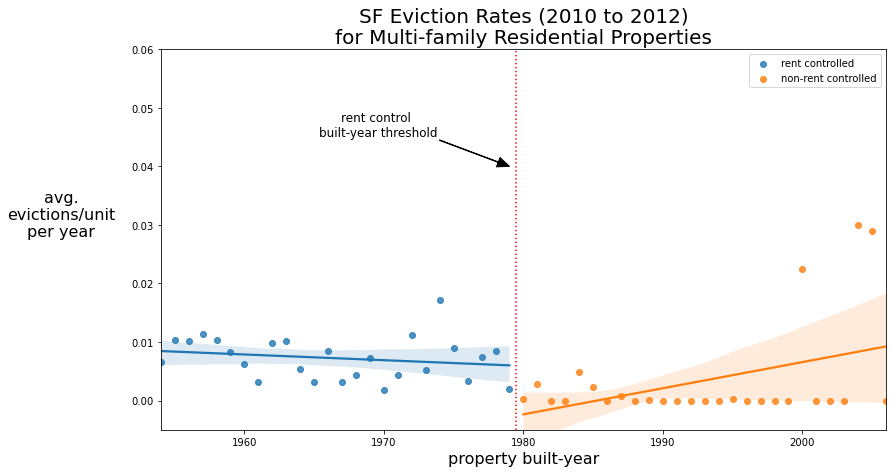

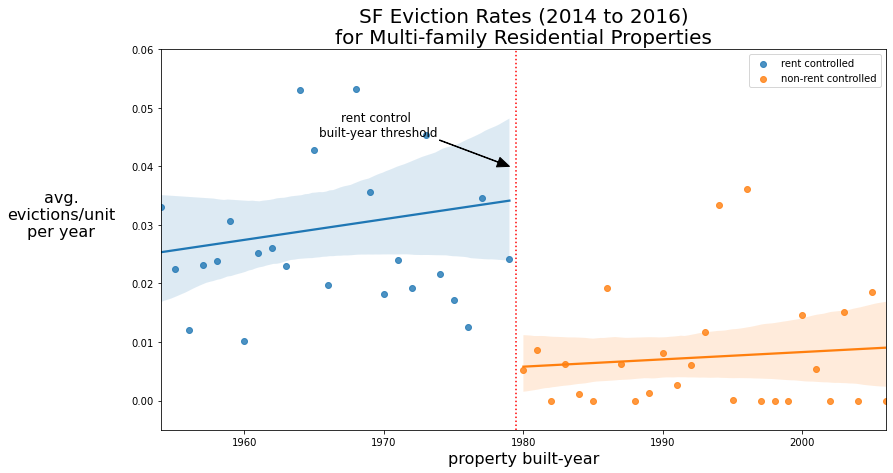

In [92]:
names = ['2010 to 2012', '2014 to 2016']
for i, asr in enumerate([asr_evic_to_13, asr_evic_from_14]):

    rc_pop = asr[
        (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1953) &
        (asr['year_built_max'] < 2007) & (asr['total_units'] > 0)]
    
    rc_pop_uniq = rc_pop.groupby('index_asr').agg(
        num_evics=('index_evic', 'count'), year_built_max=('year_built_max', 'min'), total_units=('total_units','max'))
    rc_pop_uniq['ev_per_unit'] = rc_pop_uniq['num_evics'] / rc_pop_uniq['total_units']

    yr_vs_ev = rc_pop_uniq.groupby('year_built_max').agg({
        'ev_per_unit': 'mean',
    }).reset_index()

    yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                         (yr_vs_ev['year_built_max'] >= 1953)]
    yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                         (yr_vs_ev['year_built_max'] <= 2007)]
    fig, ax = plt.subplots(figsize=(13,7))
    sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
    sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
    ax.axvline(1979.5, ls=':', c='r')
    ax.legend()
    _ = ax.set_xlabel("property built-year", fontsize=16)
    _ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=16, rotation=0, labelpad=70)
    _ = ax.set_title("SF Eviction Rates ({0})\nfor Multi-family Residential Properties".format(names[i]), fontsize=20)
    ax.set_ylim((-0.005, 0.06))
    ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction',
                arrowprops=dict(facecolor='black',frac=0.05, width=0.5, headwidth=10),
                horizontalalignment='center', verticalalignment='center', fontsize=12
                )

In [77]:
asr_evic_to_13['asr_index'].count()

5775

In [78]:
asr_evic_from_14['asr_index'].count()

8127

In [93]:
asr = asr_evic_to_13

In [95]:
bandwidth = 27

df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0)]

df['rent_control'] = False
df['pre_1980'] = df['year_built_max'] < 1980
df.loc[df['pre_1980'] == True, 'rent_control'] = True
df['year_built_centered'] = df['year_built_max'] - 1980


/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [96]:
asr_all = pd.read_csv('../data/assessor_2007-2018_clean_w_none_sttyps_fips.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,8,11,17,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
asr_all['total_value'] = asr_all['RP1LNDVAL'] + asr_all['RP1IMPVAL']
asr_all.loc[pd.isnull(asr_all['RP1NBRCDE']), 'RP1NBRCDE'] = 'unknown'

In [98]:
asr_grouped_by_yr = asr_all.groupby(['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type']).agg(
    total_units=('UNITS', 'sum'),
    diff_unit_counts=('UNITS', 'nunique'),
    min_units=('UNITS', 'min'),
    diff_bldg_types=('bldg_type', 'nunique'),
    bldg_type_min=('bldg_type', 'min'),
    bldg_type_max=('bldg_type', 'max'),
    diff_rc_eligibility=('rc_eligible', 'nunique'),
    any_rc_eligibility=('rc_eligible', 'max'),
    diff_years_built=('YRBLT', 'nunique'),
    year_built_min=('YRBLT', 'min'),
    year_built_max=('YRBLT', 'max'),
    total_value=('total_value', 'sum'),
    total_beds=('BEDS', 'sum'),
    total_baths=('BATHS', 'sum'),
    mean_stories=('STOREYNO', 'mean'),
    total_sqft=('SQFT', 'sum'),
    nbd=('RP1NBRCDE', pd.Series.mode),
    total_rooms=('ROOMS', 'sum'),
    total_area=('LAREA', 'sum')
    ).reset_index()

In [99]:
asr_grouped_by_yr['nbd'] = asr_grouped_by_yr['nbd'].apply(lambda x: list(x)[0] if type(x) == np.ndarray else x)

NameError: name 'np' is not defined

In [ ]:
asr_grouped_by_yr['yr_built_since_1900'] = asr_grouped_by_yr['year_built_max'] - 1900

In [ ]:
df_hed = asr_grouped_by_yr[
    (asr_grouped_by_yr['any_rc_eligibility'] == 1) &
    (asr_grouped_by_yr['total_units'] > 0) & 
    (asr_grouped_by_yr['year_built_max'] >= 1950) &
    (asr_grouped_by_yr['year_built_max'] <= 2010) &
    (asr_grouped_by_yr['total_sqft'] > 0) &
#     (asr_grouped_by_yr['total_beds'] > 0) 
    (asr_grouped_by_yr['total_baths'] > 0) & 
    (asr_grouped_by_yr['total_rooms'] > 0) &
    (asr_grouped_by_yr['mean_stories'] > 0) &
    (asr_grouped_by_yr['total_area'] > 0)
]

In [ ]:
df = pd.merge(
    df,
    df_hed[[
        'asr_yr', 'house_1', 'house_2', 'street_name', 'street_type', 'total_rooms',
        'total_value', 'total_area', 'total_sqft', 'nbd', 'total_baths', 'hedonic_resid']],
    on=['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type'])

In [ ]:
df['pct_non_white'] = 1 - (df['white_only_pop'] / df['total_pop_race'])
df['pct_occ_units_rental'] = df['total_rental_tenure'] / df['total_occupied_units']
df['pct_renter_pop'] = df['total_renter_pop'] / df['total_pop_tenure']
df['pct_rentals_pre2000_movein'] = (
    df['total_rental_tenure'] - df['renter_movein_2005_later'] - df['renter_movein_2000_2004']) / (
    df['total_rental_tenure'])
df['pct_renter_same_house_last_yr'] = df['renter_non_mover'] / df['total_renter_pop']

In [ ]:
rd3 = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control + "
    "np.log1p(total_value):np.log(total_sqft) + np.log(total_units) + "
    "np.log1p(median_hh_income) + "
    "pct_non_white + "
    "pct_occ_units_rental + "
    "pct_rentals_pre2000_movein",
    data=df)

In [ ]:
fitted3 = rd3.fit()
print(fitted3.summary())